In [13]:
import os.path as osp
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.backends import cudnn
import random

from configs import *


In [14]:
configs = Configs()
ROOT_DIR = configs.root_dir
image_dir = os.path.join(ROOT_DIR, 'CelebA-HQ-img')

In [15]:
def list_preprocess(image_dir, mask_dir):
    train_dataset = []
    test_dataset = []
    for i in range(len([name for name in os.listdir(image_dir) if osp.isfile(osp.join(image_dir, name))])):
        img_path = osp.join(image_dir, str(i)+'.jpg')
        label_path = osp.join(mask_dir, str(i)+'.png')
        train_dataset.append([img_path, label_path])
    return train_dataset


In [12]:
train_indices = set()
indices_file_pth = os.path.join(ROOT_DIR, 'train.txt')
with open(indices_file_pth, 'r') as file:
    train_indices = set(map(int, file.read().splitlines()))
    
sample_indices = list(range(len(os.listdir(image_dir))))
test_indices = [idx for idx in sample_indices if idx not in train_indices]

# Split indices into training and validation sets
train_indices = list(train_indices)
valid_indices = train_indices
if configs.debug:
    train_indices = train_indices[:100]         
    train_indices, valid_indices = train_test_split(train_indices, test_size=VAL_SIZE, random_state=SEED)
print(len(train_indices))
if configs.debug:
    print(len(valid_indices)) 
print(len(test_indices))

24000
6000


In [6]:

root_dir = configs.root_dir

image_dir = os.path.join(root_dir, 'CelebA-HQ-img')  # Path to image folder
mask_dir = os.path.join(root_dir, 'mask')    # Path to mask folder
train_dataset = list_preprocess(image_dir, mask_dir)
print(len(train_dataset))
# sample_indices = sample_indices

30000


In [7]:
train_dataset = list_preprocess(image_dir, mask_dir)
print(train_dataset[0])


['/home/hsu/HD/CV/CelebAMask-HQ/CelebA-HQ-img/0.jpg', '/home/hsu/HD/CV/CelebAMask-HQ/mask/0.png']


In [57]:
idx_1 = random.randint(0, len(train_indices))
idx_2 = random.randint(1, len(train_indices))
print(idx_1)
print(idx_2)
idx_1 = train_indices[idx_1]
idx_2 = train_indices[idx_2]

front_img_pt, front_mask_pt = train_dataset[idx_1]
back_img_pt, back_mask_pt = train_dataset[idx_2]

front_img = cv2.imread(front_img_pt)
front_mask = cv2.imread(front_mask_pt)
back_img = cv2.imread(back_img_pt)
back_mask = cv2.imread(back_mask_pt)

front_img = Image.open(front_img_pt).convert('RGB')
front_img = front_img.resize((512, 512), Image.BILINEAR)
front_mask = Image.open(front_mask_pt).convert('P')

back_img = Image.open(back_img_pt).convert('RGB')
back_img = back_img.resize((512, 512), Image.BILINEAR)
back_mask = Image.open(back_mask_pt).convert('P')




1751
17734


In [58]:
print(front_mask.size)
test = np.array(front_mask)
np.unique(test)

(512, 512)


array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18],
      dtype=uint8)

In [59]:
front_one_hot_mask = one_hot_encode(np.array(front_mask), 19)    # (h,w) -> (19, h, w)
back_one_hot_mask = one_hot_encode(np.array(back_mask), 19)    # (h,w) -> (19, h, w)
print(np.unique(front_one_hot_mask[0]))
print(np.unique(back_one_hot_mask[0]))

[0 1]
[0 1]


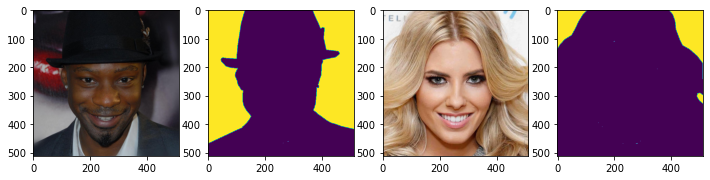

In [60]:
plt.figure(figsize=(12,12))
# front_img = cv2.cvtColor(front_img, cv2.COLOR_BGR2RGB)
# back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 4, 1)
plt.imshow(front_img)
plt.subplot(1, 4, 2)
plt.imshow(front_one_hot_mask[0])
plt.subplot(1, 4, 3)
plt.imshow(back_img)
plt.subplot(1, 4, 4)
plt.imshow(back_one_hot_mask[0])
plt.show()

In [80]:
# Specify the number of pixels to shift
tx = -256  # Shift along the x-axis (horizontal)
ty = 30  # Shift along the y-axis (vertical)

# Create the translation matrix
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

# Apply the translation using cv2.warpAffine
back_img = np.array(back_img)
front_img = np.array(front_img)
face_mask = cv2.bitwise_not(front_one_hot_mask[0])
black_image = np.zeros_like(front_img)
black_image[face_mask] = front_img[face_mask]
segmented_image = black_image
# segmented_image = cv2.bitwise_and(front_img, front_img, mask=face_mask)
translated_image = cv2.warpAffine(back_img, translation_matrix, (back_img.shape[1], back_img.shape[0]))

error: OpenCV(4.8.1) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


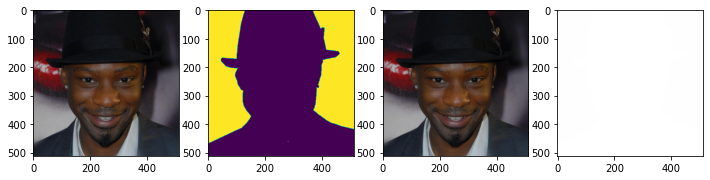

In [81]:
plt.figure(figsize=(12,12))
# front_img = cv2.cvtColor(front_img, cv2.COLOR_BGR2RGB)
# back_img = cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB)
plt.subplot(1, 4, 1)
plt.imshow(front_img)
plt.subplot(1, 4, 2)
plt.imshow(front_one_hot_mask[0])
plt.subplot(1, 4, 3)
# plt.imshow(translated_image)
plt.imshow(segmented_image)
plt.subplot(1, 4, 4)
# plt.imshow(back_one_hot_mask[0])
plt.imshow(face_mask)
plt.show()